#Implementing an Autoencoder in PyTorch

In [3]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torchvision import datasets, transforms, utils
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import math

In [17]:
class Encoder(nn.Module):
  def __init__(self, n_in, n_hidden_1, n_hidden_2, n_hidden_3, n_out):
    super(Encoder, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(n_in, n_hidden_1, bias=True),
        nn.BatchNorm1d(n_hidden_1),
        nn.Sigmoid())
    self.layer2 = nn.Sequential(
        nn.Linear(n_hidden_1, n_hidden_2, bias=True),
        nn.BatchNorm1d(n_hidden_2),
        nn.Sigmoid())
    self.layer3 = nn.Sequential(
        nn.Linear(n_hidden_2, n_hidden_3, bias=True),
        nn.BatchNorm1d(n_hidden_3),
        nn.Sigmoid())
    self.layer4 = nn.Sequential(
        nn.Linear(n_hidden_3, n_out, bias=True),
        nn.BatchNorm1d(n_out),
        nn.Sigmoid())
    
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    return self.layer4(x)

class Decoder(nn.Module):
  def __init__(self, n_in, n_hidden_1, n_hidden_2, n_hidden_3, n_out):
    super(Decoder, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(n_in, n_hidden_1, bias=True),
        nn.BatchNorm1d(n_hidden_1),
        nn.Sigmoid())
    self.layer2 = nn.Sequential(
        nn.Linear(n_hidden_1, n_hidden_2, bias=True),
        nn.BatchNorm1d(n_hidden_2),
        nn.Sigmoid())
    self.layer3 = nn.Sequential(
        nn.Linear(n_hidden_2, n_hidden_3, bias=True),
        nn.BatchNorm1d(n_hidden_3),
        nn.Sigmoid())
    n_size = math.floor(math.sqrt(n_out))
    self.layer4 = nn.Sequential(
        nn.Linear(n_hidden_3, n_out, bias=True),
        nn.BatchNorm1d(n_out),
        nn.Sigmoid(),
        nn.Unflatten(1, torch.Size([1, n_size,n_size])))
    
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    return self.layer4(x)

encoder = Encoder(784,1000,500,250,2)
decoder = Decoder(2,250,500,1000,784)

In [3]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(),
                       lr = 0.001, 
                       betas=(0.9,0.999), 
                       eps=1e-08)

In [4]:
trainset = datasets.MNIST('.',
                          train=True, 
                          transform=transforms.ToTensor(),
                          download=True)
trainloader = DataLoader(trainset,
                         batch_size=32,
                         shuffle=True)

In [5]:
print(trainset[0][0].shape)

torch.Size([1, 28, 28])


In [13]:
# Training Loop 
NUM_EPOCHS = 100
for epoch in range(NUM_EPOCHS):
  for input, labels in trainloader:
    optimizer.zero_grad()
    code = encoder(input)
    output = decoder(code)
    # print(input.shape, output.shape)
    loss = loss_fn(output, input)
    loss.backward()
    optimizer.step()
  print(f"Epoch: {epoch} Loss: {loss}")

Epoch: 0 Loss: 0.0675138458609581
Epoch: 1 Loss: 0.06848703324794769
Epoch: 2 Loss: 0.06391064822673798
Epoch: 3 Loss: 0.06689506769180298
Epoch: 4 Loss: 0.060568585991859436


KeyboardInterrupt: 

In [8]:
from sklearn import decomposition
from matplotlib import pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("data/",one_hot=False)
pca=decomposition.PCA(n_components=2)
pca.fit(mnist.train.images)
pca_codes=pca.transform(mnist.train.images)
pca_recon = pca.inverse_transform(pca_codes[:1])
plt.imshow(pca_recon[0].reshape((28,28)),cmap=plt.cm.gray)
plt.show()

ModuleNotFoundError: No module named 'input_data'

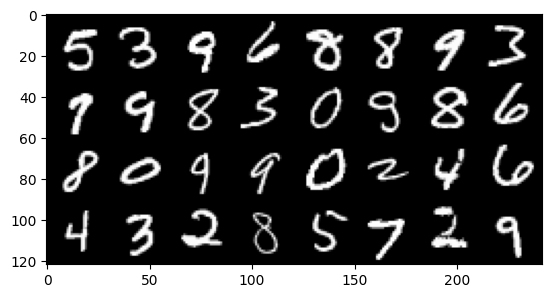

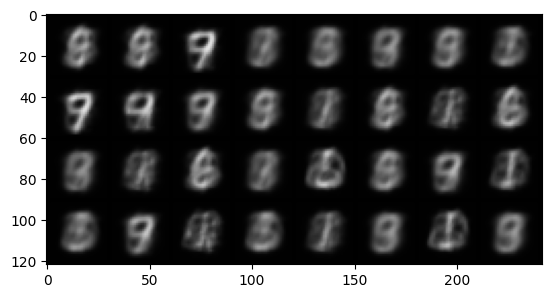

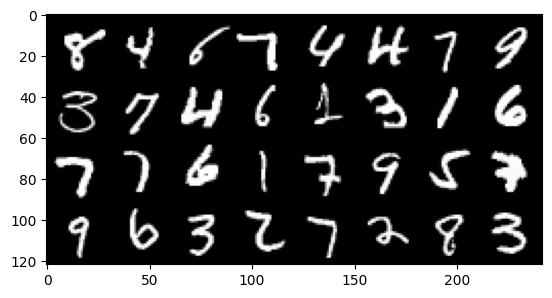

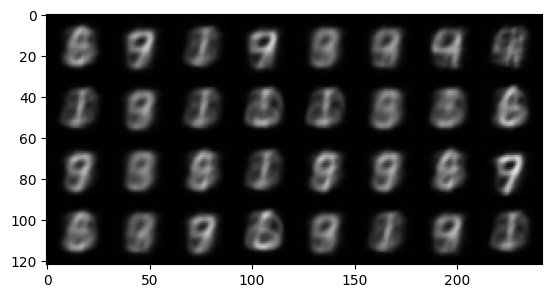

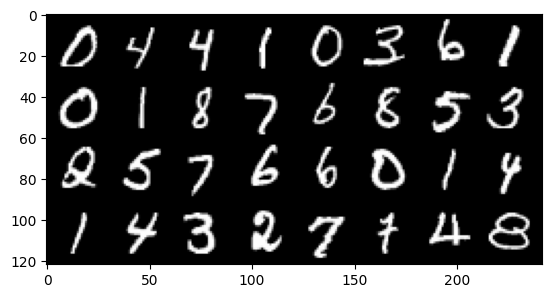

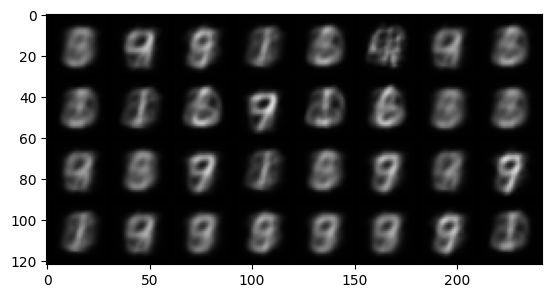

In [16]:
i = 0
with torch.no_grad():
  for images, labels in trainloader:
    if i == 3:
      break
    grid = utils.make_grid(images)
    plt.figure()
    plt.imshow(grid.permute(1,2,0))
    
    code = encoder(images)
    output = decoder(code)
    
    grid = utils.make_grid(output)
    plt.figure()
    plt.imshow(grid.permute(1,2,0))
    i += 1

# Denoising to Force Robust Representations

In [8]:
import torch

In [10]:
def corrupt_input(x):
    corrupting_matrix = 2.0*torch.rand_like(x)
    
    return x * corrupting_matrix

# x = mnist data image of shape 28*28=784
x = torch.rand((28,28))
corrupt = 1.0 # set to 1.0 to corrupt input
c_x = (corrupt_input(x) * corrupt) + (x * (1 - corrupt))

# Implementing the Skip-Gram Architecture

In [5]:
import torch.nn as nn

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
vocab_size = 500
emb_vector_len = 128

embedding = nn.Embedding(num_embeddings = vocab_size,
                         embedding_dim = emb_vector_len)

In [7]:
!pip install info-nce-pytorch

Defaulting to user installation because normal site-packages is not writeable


In [8]:
# We create dummy outputs and targets for illustrative purposes
from info_nce import InfoNCE
outputs = torch.randint(0,100,(100,100))
targets = torch.randint(0,100,(100,100))

In [1]:
# print dimensions of outputs, targets
print(outputs.shape, targets.shape)

NameError: name 'outputs' is not defined

In [13]:
loss_fn = InfoNCE()
batch_size, embedding_size = 32, 128
query = embedding(outputs)
positive_key = embedding(targets)
output = loss_fn(query, positive_key)

ValueError: <query> must have 2 dimensions.

In [9]:
import torch.optim as optim

In [14]:
optimizer = optim.SGD(embedding.parameters(), 
                      lr = 0.1)
def train(inputs, targets):
  optimizer.zero_grad()
  input_emb = embedding(inputs)
  target_emb = embedding(targets)
  loss = loss_fn(input_emb, target_emb)
  loss.backward()
  optimizer.step()
  return loss

In [15]:
cosine_similarity = nn.CosineSimilarity()

def evaluate(inputs, targets, embedding):
  with torch.no_grad():
    input_emb = embedding(inputs)
    target_emb = embedding(targets)
    norm = torch.sum(input_emb, dim=1)
    normalized = input_emb/norm
    score = cosine_similarity(normalized, target_emb)
    return normalized, score

In [12]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [16]:
n_epochs = 1
for epoch in range(n_epochs):
  # Train
  running_loss = 0.0
  for inputs, targets in trainloader:
    loss = train(inputs, targets)
    running_loss += loss.item()
  
  writer.add_scalar('Train Loss', 
                    running_loss/len(trainloader), epoch)
  #Validate
  running_score = 0.0
  for inputs, targets in valloader:
    _, score = evaluate(inputs, targets)
    running_score += score
  
  writer.add_scalar('Val Score', 
                    running_score/len(valloader), epoch) 

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.in_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.init_emb()

    def init_emb(self):
        initrange = 0.5 / self.embedding_dim
        self.in_embeddings.weight.data.uniform_(-initrange, initrange)
        self.out_embeddings.weight.data.uniform_(-0, 0)

    def forward(self, input_labels, pos_labels, neg_labels):
        """
        input_labels: center words
        pos_labels: positive context words
        neg_labels: negative sampled context words
        """
        input_embedding = self.in_embeddings(input_labels)
        pos_embedding = self.out_embeddings(pos_labels)
        neg_embedding = self.out_embeddings(neg_labels)

        log_pos = torch.bmm(pos_embedding, input_embedding.unsqueeze(2)).squeeze()
        log_neg = torch.bmm(neg_embedding.neg(), input_embedding.unsqueeze(2)).squeeze()

        log_pos = torch.sum(log_pos, dim=1)
        log_neg = torch.sum(torch.logsumexp(log_neg, dim=1))

        loss = log_pos + log_neg
        return -loss.mean()

    def input_embeddings(self):
        return self.in_embeddings.weight.data.cpu().numpy()

In [18]:
import urllib.request

url = "http://mattmahoney.net/dc/text8.zip"
file_path = "text8.zip"

# Download the file from `url` and save it locally under `file_path`:
urllib.request.urlretrieve(url, file_path)
print("Download complete.")

Download complete.


In [19]:
import zipfile

# Unzip the dataset
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(".")

print("Extraction complete.")

Extraction complete.


In [20]:
from collections import Counter
import numpy as np

def preprocess_text(file_path):
    with open(file_path, 'r') as file:
        text = file.read()
    
    # Tokenization by whitespace
    words = text.split()

    # Remove rare words
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words

# Assuming the extracted text file is named 'text8'
processed_words = preprocess_text("text8")
print(f"Number of words after preprocessing: {len(processed_words)}")

Number of words after preprocessing: 16680599


In [21]:
def generate_training_data(words, window_size=5):
    """ Generate skip-gram pairs with a specific window size """
    pairs = []
    for i, center_word in enumerate(words):
        context = words[max(i - window_size, 0) : i] + words[i + 1 : i + 1 + window_size]
        pairs.extend([(center_word, context_word) for context_word in context])
    return pairs

# Generate training pairs
skip_gram_pairs = generate_training_data(processed_words)
print(f"Number of training pairs: {len(skip_gram_pairs)}")

Number of training pairs: 166805960


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class SkipGramDataset(Dataset):
    def __init__(self, skip_gram_pairs, word_to_ix):
        super(SkipGramDataset, self).__init__()
        self.pairs = skip_gram_pairs
        self.word_to_ix = word_to_ix  # Dictionary of word to index mapping

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        center_word, context_word = self.pairs[idx]
        center_word_idx = self.word_to_ix[center_word]
        context_word_idx = self.word_to_ix[context_word]
        return torch.tensor(center_word_idx, dtype=torch.long), torch.tensor(context_word_idx, dtype=torch.long)

def build_vocab(words):
    word_count = Counter(words)
    word_to_ix = {word: i for i, word in enumerate(word_count.keys())}
    return word_to_ix

words = [pair[0] for pair in skip_gram_pairs] + [pair[1] for pair in skip_gram_pairs]
word_to_ix = build_vocab(words)

# Placeholder for actual data loading and preprocessing
# data = load_data() 

# Initialize dataset
dataset = SkipGramDataset(skip_gram_pairs, word_to_ix)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=256, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SkipGramModel(vocab_size=500, embedding_dim=128).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for center_word, context_word, negative_samples in dataloader:
        center_word = center_word.to(device)
        context_word = context_word.to(device)
        negative_samples = negative_samples.to(device)
        optimizer.zero_grad()
        loss = model(center_word, context_word, negative_samples)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Training loop
n_epochs = 5
for epoch in range(n_epochs):
    loss = train_epoch(model, data_loader, optimizer, device)
    print(f"Epoch {epoch}, Loss: {loss}")